### Term Deposit
This notebook will be performing a binary classification problem to determine if customers subscribe to term deposit or not. And looks at the features that influences the decision.

In [1]:
# I will be importing all the neccessary libraries I need to work with


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


from scipy import stats
from scipy.stats import skew

from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)

import pycaret
import lightgbm
from pycaret.classification import (setup, compare_models, tune_model)


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier,
VotingClassifier)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (classification_report, accuracy_score, roc_curve, roc_auc_score)


from lightgbm import LGBMClassifier


from sklearn.model_selection import cross_val_score

from sklearn.inspection import permutation_importance

In [2]:
# The first thing to do is to load the data into the working enviroment
customers = pd.read_csv ("C:/Users/44756/Desktop/Apziva/SecondProject  - term-deposit-marketing.csv")

In [3]:
# To see what the dataset looks like
customers.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
#To show the number of obeservations and features
customers.shape

(40000, 14)

In [5]:
#To check for missing values
customers.isnull().values.any()

False

In [6]:
# To check the different datatype for each feature

customers.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [7]:
#To check the ratio of people who have subscribe to term deposit and ones who haven't
print (customers ['y']. value_counts())

no     37104
yes     2896
Name: y, dtype: int64


Data Description : Giving the codebook of the data

- Y :(Target Variable) has the client subscribed to a term deposit?
- age : age of customer
- job : type of job
- marital : marital status
- education
- default: has credit in default?
- balance: average yearly balance
- housing: has a housing loan?
- loan: has personal loan?
- contact: contact communication type
- day: last contact day of the month
- month: last contact month of year
- duration: last contact duration, in seconds
- campaign: number of contacts performed during this campaign and for this client

In [8]:
# The feature 'contact' will be dropped because it has mostly unknown value which will be insignificant to the model
customers.drop('contact', axis = 1, inplace=True) 

In [9]:
customers.head() #to check the new dataset without the contact column

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,no


#### DATA VISUALIZATION

This will look at the distribution of data using charts.

In [10]:
#To check if it is normally distributed

n_bins = np.sqrt(len(customers))
n_bins = int(n_bins)

#create a function to plot the histogram for each feature and see if it's normally distributed

def distribution(feature, color, title):
    
    plt.hist(x = feature, bins = n_bins, color = color, data = customers)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title(title)
    return plt.show()

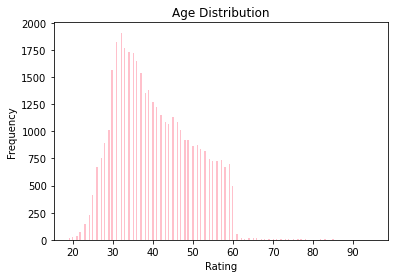

In [11]:
#Age Distribution

distribution(feature = 'age', color = 'pink', title = 'Age Distribution')

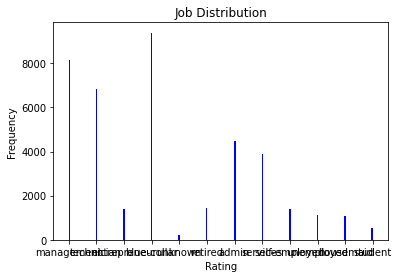

In [12]:
#Job Distribution

distribution(feature = 'job', color = 'blue', title = 'Job Distribution')

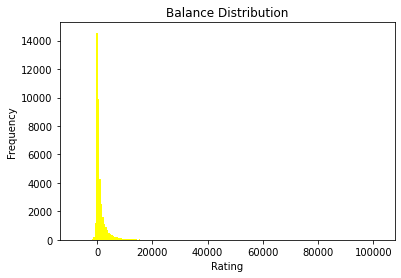

In [13]:
#Balance Distribution

distribution(feature = 'balance', color = 'yellow', title = 'Balance Distribution')

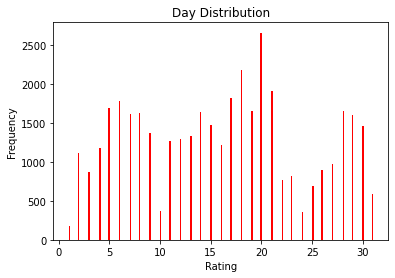

In [14]:
#Day Distribution

distribution(feature = 'day', color = 'red', title = 'Day Distribution')

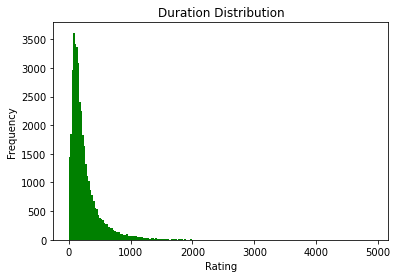

In [15]:
#Duration Distribution

distribution(feature = 'duration', color = 'green', title = 'Duration Distribution')

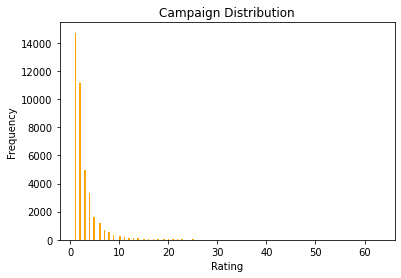

In [16]:
#Campaign Distribution

distribution(feature = 'campaign', color = 'orange', title = 'Campaign Distribution')

From the histograms, not all features are normally distributed except the 'day' feature

Campaign, Duration, Balance and Age are skewed to the left

In [17]:
#  Calculation of skewness using the pandas function

skewValue = customers.skew()

skewValue.sort_values (ascending = False)

balance     8.259236
campaign    4.730901
duration    3.165307
age         0.436080
day         0.067930
dtype: float64

#### Correlation Matrix¶

In [18]:
# creating a correlation plot with pps as an alternative to Pearson because dataset is a combination of categorical and numerical

#!pip install ppscore

In [19]:
#corelation = pps.matrix(customers)
corr = pps.matrix(customers)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values = 'ppscore') 

<AxesSubplot:xlabel='x', ylabel='y'>

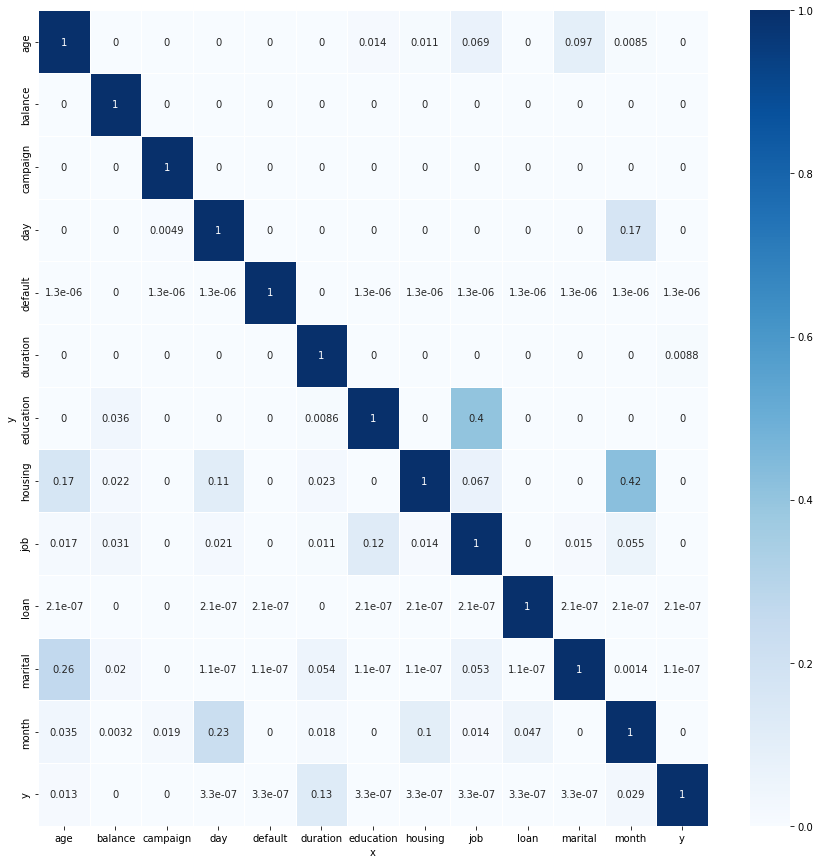

In [20]:
plt.subplots(figsize=(15,15))  # this is to enlarge the plot
sns.heatmap(corr, vmin=0, vmax=1,cmap ="Blues", linewidths=0.5, annot = True)

The target variable has a mostly 0 vlaues to all the independent variables which shows a non-linear relationship, so no feature will be dropped.

In [21]:
# Create a new column that says if customer subscribed or not 

customers['subscribe'] = customers ['y'].map ({1: 'subscribed', 0: 'not_subscribed'})

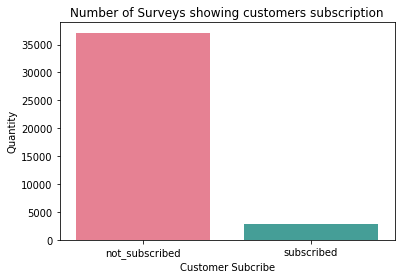

In [22]:
# To create a bar to see if there is a significant difference customers that subscribed and the ones that didn't.

sns.countplot (x = 'y', data = customers, 
              palette = 'husl')
plt.xlabel('Customer Subcribe')
plt.ylabel('Quantity')
plt.xticks([0, 1], ['not_subscribed', 'subscribed'])
plt.title("Number of Surveys showing customers subscription")
plt.show()

In [23]:
# Grouping by customer' subscription and see the average rating in each category

data_grouped = customers.groupby('y').agg('mean')
data_grouped

,age,balance,day,duration,campaign
y,,,,,
no,40.599208,1249.752533,16.032072,221.408042,2.918688
yes,39.844959,1588.495856,15.827003,682.958564,2.414365


From the above, duration and balance will be significant to the model as there's much difference in the ratio of those that subscribed and those who didn't. Others also have but not much. Campaign has about equal number of subscribers and non subsrcibers which I think will not add much value.

## Exploratory Data Analysis

I will convert the string in the target variable to numeric.

Yes = 1 and No = 0

In [24]:
def transform_y (x):
    if x == 'yes':
        return 1
    if x == 'no':
        return 0

In [25]:
customers ['subscription'] = customers['y'].apply(transform_y)
customers

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y,subscribe,subscription
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,no,NaN,0
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,no,NaN,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,no,NaN,0
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,no,NaN,0
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,no,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,3,jun,107,1,no,NaN,0
39996,30,management,single,tertiary,no,3340,no,no,3,jun,238,3,yes,NaN,1
39997,54,admin,divorced,secondary,no,200,no,no,3,jun,170,1,yes,NaN,1
39998,34,management,married,tertiary,no,1047,no,no,3,jun,342,1,no,NaN,0


## Feature Engineering

In [26]:
# I am suppose to do some type of normalization to scale my skewed features but I couldn't get any method to work

In [27]:
# Deleting y and subscribe column from the dataset
customers.drop('y',  axis = 1, inplace=True)
customers.drop('subscribe',  axis = 1, inplace=True)

In [28]:
# I will convert the categorical varibles into 

Ncustomers = pd.get_dummies(customers, columns = ['job','marital', 'education', 'default', 'housing', 'loan', 'month',
                                       ], drop_first = False)

# I am using all the features becuase I can't fully grasp the plot to determine which feature to drop. So for now, I'll use all

In [29]:
# We are dividing the data into the train and the test data set. 
# Since the dataset is very small, we may have problems with overfitting the data
# We will evaluate the model in terms on how it behaves with the test data set

# Creation of the X (independent variables) and the y arrays (dependant variables)

X = Ncustomers.drop(columns = 'subscription', axis = 1).values
y = Ncustomers['subscription'].values
# Division of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20)

In [30]:
# Function that converts the arrays created to data frame

def converter_df(train_independent, train_dependent):
    df = pd.DataFrame(train_independent)
    df['dependant'] = train_dependent
    return df

In [31]:
# Convert the array of train data set into data frames

df = converter_df(train_independent = X_train, train_dependent = y_train)

## Modelling
I will use PyCaret first to check what classifiers better perform on the dataset

In [32]:
# setup the dataset

grid = setup (data = df, target = df.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029
qda,Quadratic Discriminant Analysis,0.5459,0.5055,0.4584,0.0753,0.1268,0.0052,0.0043,0.052


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
ada,Ada Boost Classifier,0.9291,0.9177,0.2856,0.5231,0.3684,0.3343,0.3521,0.402
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029
qda,Quadratic Discriminant Analysis,0.5459,0.5055,0.4584,0.0753,0.1268,0.0052,0.0043,0.052


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9373,0.9339,0.3329,0.6327,0.4342,0.4044,0.4289,1.383
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
ada,Ada Boost Classifier,0.9291,0.9177,0.2856,0.5231,0.3684,0.3343,0.3521,0.402
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029
qda,Quadratic Discriminant Analysis,0.5459,0.5055,0.4584,0.0753,0.1268,0.0052,0.0043,0.052


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9373,0.9339,0.3329,0.6327,0.4342,0.4044,0.4289,1.383
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
lda,Linear Discriminant Analysis,0.9313,0.9160,0.4097,0.5392,0.4642,0.4283,0.4336,0.077
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
ada,Ada Boost Classifier,0.9291,0.9177,0.2856,0.5231,0.3684,0.3343,0.3521,0.402
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093
nb,Naive Bayes,0.9042,0.8387,0.4622,0.3722,0.4118,0.3604,0.3632,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9373,0.9339,0.3329,0.6327,0.4342,0.4044,0.4289,1.383
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
et,Extra Trees Classifier,0.9320,0.9040,0.2140,0.5873,0.3127,0.2851,0.3263,0.761
lda,Linear Discriminant Analysis,0.9313,0.9160,0.4097,0.5392,0.4642,0.4283,0.4336,0.077
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
ada,Ada Boost Classifier,0.9291,0.9177,0.2856,0.5231,0.3684,0.3343,0.3521,0.402
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085
dt,Decision Tree Classifier,0.9094,0.6800,0.4117,0.3838,0.3970,0.3481,0.3485,0.093


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9385,0.9407,0.3887,0.6245,0.4778,0.4471,0.4620,0.286
gbc,Gradient Boosting Classifier,0.9373,0.9339,0.3329,0.6327,0.4342,0.4044,0.4289,1.383
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
et,Extra Trees Classifier,0.9320,0.9040,0.2140,0.5873,0.3127,0.2851,0.3263,0.761
lda,Linear Discriminant Analysis,0.9313,0.9160,0.4097,0.5392,0.4642,0.4283,0.4336,0.077
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
ada,Ada Boost Classifier,0.9291,0.9177,0.2856,0.5231,0.3684,0.3343,0.3521,0.402
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9385,0.9407,0.3887,0.6245,0.4778,0.4471,0.4620,0.286
gbc,Gradient Boosting Classifier,0.9373,0.9339,0.3329,0.6327,0.4342,0.4044,0.4289,1.383
rf,Random Forest Classifier,0.9347,0.9253,0.2652,0.6233,0.3692,0.3408,0.3770,0.801
lr,Logistic Regression,0.9329,0.9085,0.2318,0.5979,0.3331,0.3049,0.3438,1.632
et,Extra Trees Classifier,0.9320,0.9040,0.2140,0.5873,0.3127,0.2851,0.3263,0.761
lda,Linear Discriminant Analysis,0.9313,0.9160,0.4097,0.5392,0.4642,0.4283,0.4336,0.077
ridge,Ridge Classifier,0.9306,0.0000,0.1221,0.6053,0.2028,0.1830,0.2499,0.031
ada,Ada Boost Classifier,0.9291,0.9177,0.2856,0.5231,0.3684,0.3343,0.3521,0.402
knn,K Neighbors Classifier,0.9259,0.7635,0.2639,0.4815,0.3405,0.3048,0.3205,0.228
svm,SVM - Linear Kernel,0.9164,0.0000,0.2241,0.3727,0.2577,0.2200,0.2359,0.085


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5053, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [33]:
# Separate the data frames between customers that subscribed and the ones that didn't.

condition1 = Ncustomers['subscription'] == 1
subscribed_customers = Ncustomers.loc[condition1].reset_index(drop = True)

condition2 = Ncustomers['subscription'] == 0
unsubscribed_customers = Ncustomers.loc[condition2].reset_index(drop = True)

In [34]:
# There are more customers that didn't subscribe than the ones that did
# I'm making a balanced data set with the length of the ones that didn't subscribe

length = len(unsubscribed_customers)

# Separate the data set into subscribe & unsubscribe customers to make the bootstrapping technique

array1 = subscribed_customers.values
array2 = unsubscribed_customers.values

In [35]:
# Make the bootstrapping for the subscribe customers

# Establish 100 iterations
n_iterations = 1000

#Empty list that will be my main bagging
boots_subscribe = []

#Empty list for the unsubscribe customers
boots_unsubscribe = []

# Create the for loop for the subscribe customers for storage in the bagging

for i in range(n_iterations):
    idx_pick = np.random.choice(a = np.arange(0,2897))
    boot = array1[idx_pick]
    boots_subscribe.append(boot)
    
# Create the for loop for the unsubscribe customers to storage in the baggging
    
for i in range(n_iterations):
    idx_pick = np.random.choice(np.arange(0,2897))
    boot = array2[idx_pick]
    boots_unsubscribe.append(boot)

In [36]:
# Select 2897 samples from the main bagging
n_samples = 2897

# Storage the 2897 samples of subscribe customers in a list
subscribe_customers = []

# Storage the 2897 samples of unsubscribe customers in another list
unsubscribe_customers = []

# For loop for happy customers

for i in range(n_samples):
    idx_pick = np.random.choice(a = np.arange(0, n_iterations))
    boot = boots_subscribe[idx_pick]
    subscribe_customers.append(boot)
    
# For loop for unhappy customers

for i in range(n_samples):
    idx_pick = np.random.choice(a = np.arange(0, n_iterations))
    boot = boots_unsubscribe[idx_pick]
    unsubscribe_customers.append(boot)

In [37]:
# Data Frame for the subscribed customers
subscribe_df = pd.DataFrame(subscribe_customers)
subscribe_df.columns = Ncustomers.columns[:]

# Data Frame for the unsubscribed customers
unsubscribe_df = pd.DataFrame(unsubscribe_customers)
unsubscribe_df.columns = Ncustomers.columns[:]

# Concat the two data frames to have the balanced data set

data_balanced = pd.concat([subscribe_df, unsubscribe_df], axis = 0).reset_index(drop = True)

In [38]:
# We are dividing the data into the train and the test data set. 
# Since the dataset is very small, we may have problems with overfitting the data
# We will evaluate the model in terms on how it behaves with the test data set

# Creation of the X (all independent variables) and the y arrays (dependant variables)

X = data_balanced.drop(columns = 'subscription', axis = 1).values
y = data_balanced['subscription'].values

# Division of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20)

In [39]:
# Convert the input to data frames

df = converter_df(train_independent = X_train, train_dependent = y_train)

In [40]:
# setup the new balanced dataset 
grid = setup(data = df, target = df.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models
best = compare_models()

# report the best model
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9441,0.9816,0.923,0.9628,0.9423,0.8881,0.8892,0.212


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016
qda,Quadratic Discriminant Analysis,0.6570,0.6592,0.8879,0.6144,0.7220,0.3173,0.3566,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
ada,Ada Boost Classifier,0.9734,0.9963,0.9668,0.9794,0.9729,0.9467,0.9471,0.115
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016
qda,Quadratic Discriminant Analysis,0.6570,0.6592,0.8879,0.6144,0.7220,0.3173,0.3566,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
gbc,Gradient Boosting Classifier,0.9783,0.9982,0.9728,0.9834,0.9780,0.9566,0.9569,0.244
ada,Ada Boost Classifier,0.9734,0.9963,0.9668,0.9794,0.9729,0.9467,0.9471,0.115
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016
qda,Quadratic Discriminant Analysis,0.6570,0.6592,0.8879,0.6144,0.7220,0.3173,0.3566,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
gbc,Gradient Boosting Classifier,0.9783,0.9982,0.9728,0.9834,0.9780,0.9566,0.9569,0.244
ada,Ada Boost Classifier,0.9734,0.9963,0.9668,0.9794,0.9729,0.9467,0.9471,0.115
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
lda,Linear Discriminant Analysis,0.9030,0.9819,0.8162,0.9859,0.8924,0.8057,0.8183,0.026
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076
svm,SVM - Linear Kernel,0.7498,0.0000,0.7878,0.7334,0.7387,0.4997,0.5159,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
et,Extra Trees Classifier,0.9859,0.9994,0.9768,0.9946,0.9856,0.9717,0.9719,0.250
gbc,Gradient Boosting Classifier,0.9783,0.9982,0.9728,0.9834,0.9780,0.9566,0.9569,0.244
ada,Ada Boost Classifier,0.9734,0.9963,0.9668,0.9794,0.9729,0.9467,0.9471,0.115
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
lda,Linear Discriminant Analysis,0.9030,0.9819,0.8162,0.9859,0.8924,0.8057,0.8183,0.026
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012
knn,K Neighbors Classifier,0.8517,0.9327,0.8381,0.8605,0.8482,0.7033,0.7049,0.076


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9898,0.9990,0.9881,0.9914,0.9897,0.9796,0.9797,0.056
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
et,Extra Trees Classifier,0.9859,0.9994,0.9768,0.9946,0.9856,0.9717,0.9719,0.250
gbc,Gradient Boosting Classifier,0.9783,0.9982,0.9728,0.9834,0.9780,0.9566,0.9569,0.244
ada,Ada Boost Classifier,0.9734,0.9963,0.9668,0.9794,0.9729,0.9467,0.9471,0.115
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
lda,Linear Discriminant Analysis,0.9030,0.9819,0.8162,0.9859,0.8924,0.8057,0.8183,0.026
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9898,0.9990,0.9881,0.9914,0.9897,0.9796,0.9797,0.056
dt,Decision Tree Classifier,0.9895,0.9895,0.9887,0.9902,0.9894,0.9790,0.9791,0.012
rf,Random Forest Classifier,0.9895,0.9994,0.9881,0.9907,0.9894,0.9790,0.9790,0.255
et,Extra Trees Classifier,0.9859,0.9994,0.9768,0.9946,0.9856,0.9717,0.9719,0.250
gbc,Gradient Boosting Classifier,0.9783,0.9982,0.9728,0.9834,0.9780,0.9566,0.9569,0.244
ada,Ada Boost Classifier,0.9734,0.9963,0.9668,0.9794,0.9729,0.9467,0.9471,0.115
lr,Logistic Regression,0.9441,0.9816,0.9230,0.9628,0.9423,0.8881,0.8892,0.212
lda,Linear Discriminant Analysis,0.9030,0.9819,0.8162,0.9859,0.8924,0.8057,0.8183,0.026
ridge,Ridge Classifier,0.9027,0.0000,0.8156,0.9859,0.8920,0.8050,0.8177,0.011
nb,Naive Bayes,0.8833,0.9586,0.7797,0.9814,0.8684,0.7661,0.7830,0.012


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4623, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


From the results, I conclude that I'm using the balanced dataset with the all features to get the results with more accuracy

To create the best possible model, I'll use the models Logistic Regression, Random Forest Classifier, Decision Tree Classifier, K Neighbors Classifier, long gradient boosting machine, Extra Tree Classifier, and gradient boosting classifier and depending on the results of each individual classifier, a voting classifier.

## Modelling
Logistic Regression

In [41]:
# Do the Grid Search Cross Validation 

param_grid = {
             'penalty': ['l1', 'l2', None],
             'tol': [0.01, 0.1, 1.0],
             'C':[0.01, 0.1, 1.0]
             }

lr = LogisticRegression(solver='liblinear')
cv_lr = GridSearchCV(lr, param_grid, cv = 5)
cv_lr_fit = cv_lr.fit(X_train, y_train)

#Print the best parameter

print(cv_lr_fit.best_params_)

{'C': 1.0, 'penalty': 'l1', 'tol': 0.01}


In [42]:
# Make the model with the best hyperparameters

lr = LogisticRegression(C = 1.0, penalty = 'l2', tol = 0.01)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [43]:
# Check out train score

print('The model score for Logistic Regression is {}'.format(lr.score(X_train, y_train)))

The model score for Logistic Regression is 0.9003452243958573


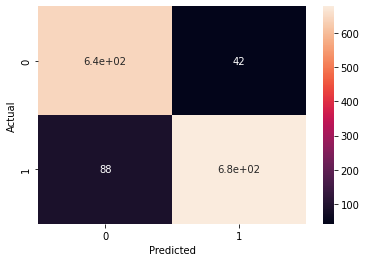

In [44]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': lr_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [45]:
# Print of the Classification Report

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       683
           1       0.94      0.89      0.91       766

    accuracy                           0.91      1449
   macro avg       0.91      0.91      0.91      1449
weighted avg       0.91      0.91      0.91      1449



In [46]:
# Predict the probabilities

pred_proba = lr.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

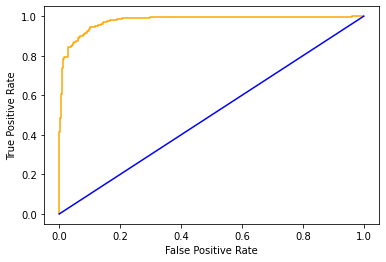

In [47]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [48]:
# Create a function tht converts the predict probabilities to a data frame that compares to the test dataset.
# This will be done in order to evaluate different thresholds in order to see if I can improve the performance with
# different thresholds

def df_converter_test(pred_prob):
    df = pd.DataFrame()
    df['pred_prob'] = pred_prob
    df['test'] = y_test
    return df

# Create a function that converts the predicted probabilities into binary results

def predictor(threshold):
    predictions = []
    for pred_prob in pred_prob_list:
        if pred_prob < threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

In [49]:
# See the unique values for the predicted probabilites

np.unique(pred_proba)

array([0.00399696, 0.00418275, 0.00430997, 0.00524313, 0.00530335,
       0.00575283, 0.00593783, 0.00636535, 0.00646151, 0.00648066,
       0.00650335, 0.00655004, 0.00664822, 0.00672625, 0.00692619,
       0.00715328, 0.00718216, 0.00765347, 0.00768016, 0.00772452,
       0.00773852, 0.00811449, 0.00811961, 0.00814781, 0.00836759,
       0.00872926, 0.00878843, 0.00902449, 0.00906759, 0.00913278,
       0.00914111, 0.00953942, 0.00956044, 0.00963312, 0.00973721,
       0.00979287, 0.00982193, 0.00987019, 0.0098898 , 0.00991648,
       0.01033171, 0.01044446, 0.01046701, 0.01049103, 0.01115534,
       0.0112434 , 0.01129258, 0.0115334 , 0.01169502, 0.01174032,
       0.01176422, 0.01180278, 0.01181457, 0.01182132, 0.01189985,
       0.01191557, 0.01200894, 0.01205137, 0.0121848 , 0.01221024,
       0.01224403, 0.01242967, 0.01273669, 0.01286721, 0.01302112,
       0.01304573, 0.01315348, 0.0132762 , 0.01335649, 0.01358342,
       0.01367848, 0.01390617, 0.01395002, 0.01412772, 0.01419

In [50]:
# Apply the defined function to evaluate different thresholds

# Convert the predicted probabilities to a data frame

df = df_converter_test(pred_prob = pred_proba)

# Have the values as a list

pred_prob_list = list(df['pred_prob'])

#Establish the thresholds

thresholds = [0.4, 0.5, 0.6]

In [51]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [52]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.5: 0.9102829537612146
Accuracy Score with a threshold of 0.6: 0.904071773636991
Accuracy Score with a threshold of 0.7: 0.8916494133885439


## Decision Tree Classifier

In [53]:
# Do the Grid Search Cross Validation 

param_grid = {
             'criterion': ['gini', 'entropy'],
             'max_depth': [3, 5, 7],
             'min_samples_split':[2, 4, 6, 8]
             }

dt = DecisionTreeClassifier()
cv_dt = GridSearchCV(dt, param_grid, cv = 5)
cv_dt_fit = cv_dt.fit(X_train, y_train)

#Print the best parameter
print(cv_dt_fit.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}


In [54]:
# Make the model with the best hyperparameters

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_split = 4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [55]:
# Check out train score

print('The model score for the Decision Tree Classifier is {}'.format(dt.score(X_train, y_train)))

The model score for the Decision Tree Classifier is 0.9544303797468354


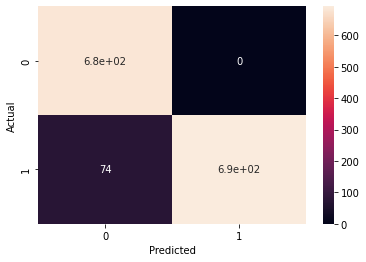

In [56]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': dt_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [57]:
# Print of the Classification Report

print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       683
           1       1.00      0.90      0.95       766

    accuracy                           0.95      1449
   macro avg       0.95      0.95      0.95      1449
weighted avg       0.95      0.95      0.95      1449



In [58]:
# Print the accuracy of the model

print('Accuracy of the Decision Tree Classifier model: {}'.format(accuracy_score(y_test, dt_pred)))

Accuracy of the Decision Tree Classifier model: 0.9489302967563837


In [59]:
# Predict the probabilities

pred_proba = dt.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

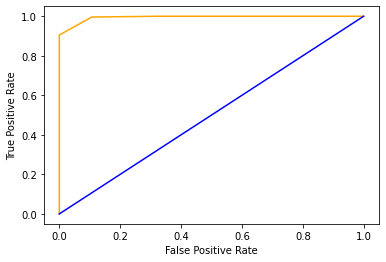

In [60]:
 #Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [61]:
# See the unique values for the predicted probabilites

np.unique(pred_proba)

array([0.        , 0.02904564, 0.16666667, 0.42962963, 0.47058824,
       0.96969697, 1.        ])

In [62]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [63]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.5: 0.9102829537612146
Accuracy Score with a threshold of 0.6: 0.904071773636991
Accuracy Score with a threshold of 0.7: 0.8916494133885439


## Random Forest Classifier

In [64]:
# Do the Grid Search Cross Validation
param_grid = {'n_estimators': [100, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth': [3, 5, 7],
              }

rf = RandomForestClassifier()
cv_rf = GridSearchCV(rf, param_grid, cv = 5)
cv_rf_fit = cv_rf.fit(X_train, y_train)

#Print the best parameter
print(cv_rf_fit.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}


In [65]:
# Make the model with the best hyperparameters

rf = RandomForestClassifier(criterion = 'gini',max_depth = 5, n_estimators = 100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [66]:
# Check out train score
print('The model score for the Decision Tree Classifier is {}'.format(rf.score(X_train, y_train)))

The model score for the Decision Tree Classifier is 0.9362485615650172


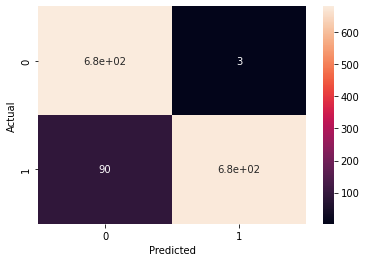

In [67]:
# Plot of the confusion matrix
grid = {'y_test':    y_test,
        'pred': rf_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [68]:
# Print of the Classification Report

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       683
           1       1.00      0.88      0.94       766

    accuracy                           0.94      1449
   macro avg       0.94      0.94      0.94      1449
weighted avg       0.94      0.94      0.94      1449



In [69]:
print('Accuracy of the Random Forest Classifier model: {}'.format(accuracy_score(y_test, rf_pred)))

Accuracy of the Random Forest Classifier model: 0.9358178053830227


In [70]:
# Predict the probabilities

pred_proba = rf.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

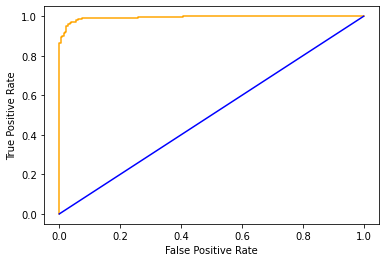

In [71]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [72]:
# Check out the unique values for the probabilities for the Random Forest Classifier

np.unique(pred_proba)

array([0.09259335, 0.09864157, 0.0989491 , 0.09930365, 0.09983414,
       0.10007554, 0.10013044, 0.10106446, 0.1011721 , 0.10126776,
       0.10138446, 0.10222197, 0.10230627, 0.10240991, 0.10243635,
       0.10252004, 0.10261799, 0.10271337, 0.10282813, 0.10294077,
       0.10338935, 0.10353088, 0.10402456, 0.10405666, 0.1041322 ,
       0.10439305, 0.10440692, 0.10463258, 0.10473455, 0.1051217 ,
       0.10513589, 0.10517492, 0.10524179, 0.10559829, 0.10596538,
       0.10618777, 0.10629276, 0.10633613, 0.10663039, 0.10669221,
       0.10688352, 0.10698217, 0.10702147, 0.10713455, 0.10716971,
       0.10774433, 0.10782543, 0.10885749, 0.10907076, 0.1090855 ,
       0.10919638, 0.10920335, 0.10921995, 0.10974317, 0.11000814,
       0.11004268, 0.11012981, 0.1101866 , 0.11091574, 0.11101239,
       0.11102197, 0.11103649, 0.11119909, 0.11130673, 0.11135488,
       0.11218126, 0.11218591, 0.11219003, 0.11224632, 0.11251973,
       0.1125393 , 0.11254154, 0.11266607, 0.11287865, 0.11288

In [73]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [74]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)
df['threshold_0.8'] = predictor(threshold = 0.8)

In [75]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))
print('Accuracy Score with a threshold of 0.8: {}'.format(accuracy_score(y_test, df['threshold_0.8'])))

Accuracy Score with a threshold of 0.3: 0.9385783298826778
Accuracy Score with a threshold of 0.4: 0.9585921325051759
Accuracy Score with a threshold of 0.5: 0.9358178053830227
Accuracy Score with a threshold of 0.6: 0.9220151828847482
Accuracy Score with a threshold of 0.7: 0.8999309868875086
Accuracy Score with a threshold of 0.8: 0.8219461697722568


## K-Nearest Neighbors

In [76]:
# Create the parameter grid

param_grid = {'n_neighbors': [5, 7, 9],
             'weights': ['uniform', 'distance'],
                }

#Create the model
knn = KNeighborsClassifier()

# Make the Grid Search Cross Validation
cv_knn = GridSearchCV(knn, param_grid, cv = 5)

cv_knn.fit(X_train, y_train)

#Print the best parameter
print(cv_knn.best_params_)

{'n_neighbors': 7, 'weights': 'distance'}


In [77]:
# Create the model with the optimized parameter
kn = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')
kn.fit(X_train, y_train)
pred_kn = kn.predict(X_test)

In [78]:
# Check out train score
print('The model score for the K-Nearest Neighbor Classifier is {}'.format(kn.score(X_train, y_train)))

The model score for the K-Nearest Neighbor Classifier is 1.0


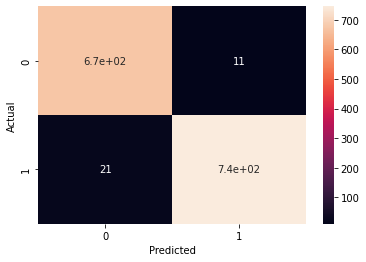

In [79]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_kn
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [80]:
# Print the Classification Report

print(classification_report(y_test, pred_kn))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.99      0.97      0.98       766

    accuracy                           0.98      1449
   macro avg       0.98      0.98      0.98      1449
weighted avg       0.98      0.98      0.98      1449



In [81]:
print('Accuracy of the KNeighbors Classifier model: {}'.format(accuracy_score(y_test, pred_kn)))

Accuracy of the KNeighbors Classifier model: 0.9779158040027606


In [82]:
# Predict the probabilities

pred_proba = kn.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

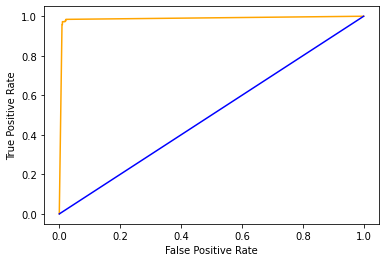

In [83]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [84]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([0.        , 0.0969784 , 0.11196992, 0.11744166, 0.16228374,
       0.18989387, 0.23757405, 0.26826183, 0.28579197, 0.29212438,
       0.30576151, 0.32858646, 0.34463779, 0.42142895, 0.49383653,
       0.50232441, 0.50861486, 0.61799424, 0.66580089, 0.67771118,
       0.69250389, 0.70642631, 0.73144319, 0.76624412, 0.78541217,
       0.80498192, 0.84459179, 0.85086326, 0.8869251 , 0.91123298,
       0.9203125 , 1.        ])

In [85]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.5, 0.7, 0.8]

In [86]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)
df['threshold_0.8'] = predictor(threshold = 0.8)

In [87]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))
print('Accuracy Score with a threshold of 0.8: {}'.format(accuracy_score(y_test, df['threshold_0.8'])))

Accuracy Score with a threshold of 0.5: 0.9779158040027606
Accuracy Score with a threshold of 0.6: 0.9799861973775017
Accuracy Score with a threshold of 0.7: 0.9765355417529331
Accuracy Score with a threshold of 0.8: 0.9730848861283644


## Extra Trees Classifier

In [88]:
# Do the Grid Search Cross Validation

param_grid = {'n_estimators':[100, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth':[3,5,7]
                }

#Create the model

et = ExtraTreesClassifier()

# Make the Grid Search Cross Validation

cv_et = GridSearchCV(et, param_grid, cv = 5)

cv_et.fit(X_train, y_train)

#Print the best parameter

print(cv_et.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}


In [89]:
# Create the model with the best hyperparameters

et = ExtraTreesClassifier(criterion = 'gini', max_depth = 3, n_estimators = 100)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)

In [90]:
# Check out train score

print('The model score for the Extra Trees Classifier is {}'.format(et.score(X_train, y_train)))

The model score for the Extra Trees Classifier is 0.8821634062140391


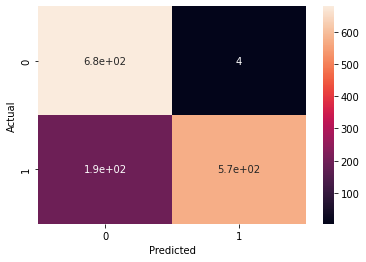

In [91]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_et
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [92]:
# Print the Classification Report

print(classification_report(y_test, pred_et))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       683
           1       0.99      0.75      0.85       766

    accuracy                           0.86      1449
   macro avg       0.89      0.87      0.86      1449
weighted avg       0.89      0.86      0.86      1449



In [93]:
print('Accuracy of the Extra Trees Classifier model: {}'.format(accuracy_score(y_test, pred_et)))

Accuracy of the Extra Trees Classifier model: 0.8640441683919945


In [94]:
# Predict the probabilities

pred_proba = et.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

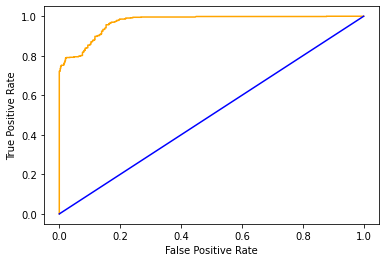

In [95]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [96]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([0.22177519, 0.22584446, 0.22666528, 0.22682185, 0.22685114,
       0.22764267, 0.22808036, 0.22810964, 0.22849671, 0.22890118,
       0.22908704, 0.23031711, 0.2306188 , 0.23105649, 0.23116636,
       0.23169399, 0.23212166, 0.23221153, 0.23256598, 0.23267139,
       0.23321956, 0.23329239, 0.23336036, 0.23347003, 0.2339299 ,
       0.23411321, 0.23429085, 0.23483117, 0.23559626, 0.23564752,
       0.23663923, 0.23678405, 0.23690602, 0.23715701, 0.23731388,
       0.23742356, 0.23896452, 0.23914192, 0.2392524 , 0.23931957,
       0.23977963, 0.24022303, 0.24105334, 0.24149102, 0.24372692,
       0.24454774, 0.24461424, 0.24509859, 0.24525175, 0.24543506,
       0.24608205, 0.24623607, 0.24651156, 0.24657443, 0.24706339,
       0.24918296, 0.24953384, 0.25085665, 0.25124282, 0.25126478,
       0.25147681, 0.25185642, 0.25188897, 0.25193337, 0.25227173,
       0.25275419, 0.25280752, 0.25295759, 0.25314747, 0.25350068,
       0.25371157, 0.25386164, 0.25412487, 0.25416927, 0.25419

In [97]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

In [98]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [99]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.3: 0.8723257418909592
Accuracy Score with a threshold of 0.4: 0.8723257418909592
Accuracy Score with a threshold of 0.5: 0.8640441683919945
Accuracy Score with a threshold of 0.6: 0.8398895790200138
Accuracy Score with a threshold of 0.7: 0.8129744651483782


## Light Gradient Boosting Machine

In [100]:
# Establish the parameter grid and the GridSearchCV

param_grid_lg = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                 'learning_rate': [0.1, 1.0]
                }
               
    
#Create the model

lg = LGBMClassifier()

# Make the Grid Search Cross Validation

cv_lg = GridSearchCV(lg, param_grid_lg, cv = 5)

cv_lg.fit(X_train, y_train)

#Print the best parameter

print(cv_lg.best_params_)


{'boosting_type': 'gbdt', 'learning_rate': 0.1}


In [101]:
# Create the model with the best hyperparameters

lg = LGBMClassifier(boosting_type = 'goss', learning_rate = 0.1)
lg.fit(X_train, y_train)
pred_lg =lg.predict(X_test)


# create the model with the best hyperparamenters

#lg, lg_pred = model_fit(model = LGBMClassifier(boosting_type = 'goss', learning_rate = 0.1))

In [102]:
# Report Cross Validation Scores  #check out the train score

#scores = cross_val_score(estimator = LGBMClassifier(boosting_type = 'goss', learning_rate = 0.1), 
                        # X = X_train, y = y_train, cv=5)

#print (scores)


print('The model score for the Light Gradient Boosting Machine is {}'.format(lg.score(X_train, y_train)))

The model score for the Light Gradient Boosting Machine is 1.0


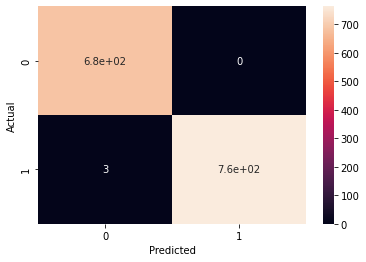

In [103]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_lg
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [104]:
# Print the Classification Report

print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       683
           1       1.00      1.00      1.00       766

    accuracy                           1.00      1449
   macro avg       1.00      1.00      1.00      1449
weighted avg       1.00      1.00      1.00      1449



In [105]:
print('Accuracy of the Light Gradient Boosting Machine model: {}'.format(accuracy_score(y_test, pred_lg)))

Accuracy of the Light Gradient Boosting Machine model: 0.9979296066252588


In [106]:
# Predict the probabilities

pred_proba = lg.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

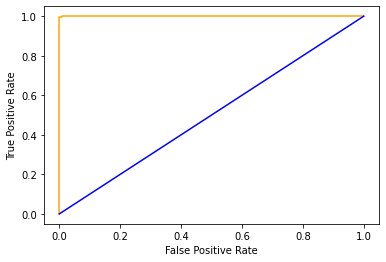

In [107]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [108]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([2.57366250e-05, 2.90168162e-05, 2.90819860e-05, 2.94514008e-05,
       2.97143710e-05, 2.99343502e-05, 3.02366625e-05, 3.02762756e-05,
       3.05415619e-05, 3.05815745e-05, 3.11472083e-05, 3.20747593e-05,
       3.23981930e-05, 3.24165535e-05, 3.25935771e-05, 3.26362779e-05,
       3.31958341e-05, 3.36046759e-05, 3.40134752e-05, 3.41503166e-05,
       3.43023345e-05, 3.43093226e-05, 3.46029347e-05, 3.50125584e-05,
       3.52235690e-05, 3.54204095e-05, 3.61910789e-05, 3.63116363e-05,
       3.70285647e-05, 3.70946059e-05, 3.71679215e-05, 3.76625931e-05,
       3.77509441e-05, 3.79560369e-05, 3.79574449e-05, 3.80057628e-05,
       3.80497197e-05, 3.82387497e-05, 3.91521720e-05, 3.93995191e-05,
       3.95042660e-05, 3.96962427e-05, 4.00174371e-05, 4.02022797e-05,
       4.03368227e-05, 4.04013062e-05, 4.10379672e-05, 4.13195488e-05,
       4.15609881e-05, 4.16030356e-05, 4.16741431e-05, 4.17579263e-05,
       4.19874538e-05, 4.20556592e-05, 4.20812701e-05, 4.23239245e-05,
      

In [109]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

In [110]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [111]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.3: 0.9979296066252588
Accuracy Score with a threshold of 0.4: 0.9979296066252588
Accuracy Score with a threshold of 0.5: 0.9979296066252588
Accuracy Score with a threshold of 0.6: 0.9979296066252588
Accuracy Score with a threshold of 0.7: 0.9979296066252588


## Gradient Boosting Classsifier


In [112]:
# Do the Grid Search Cross Validation

param_grid = {'n_estimators': [100, 300],
                 'max_depth': [3, 5, 7, None],
                 'learning_rate': [0.1, 1.0],
                 
                }


#Create the model

gb = GradientBoostingClassifier()

# Make the Grid Search Cross Validation

cv_gb = GridSearchCV(gb, param_grid, cv = 5)

cv_gb.fit(X_train, y_train)

#Print the best parameter

print(cv_gb.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [113]:
# Create the model with the best hyperparameters

gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 300)
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)


In [114]:
# Check out train score

print('The model score for the Extra Trees Classifier is {}'.format(gb.score(X_train, y_train)))

The model score for the Extra Trees Classifier is 1.0


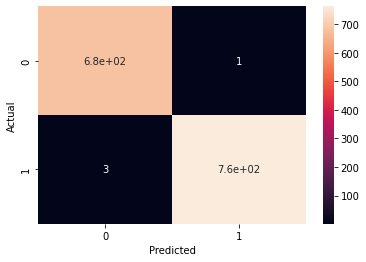

In [115]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_gb
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [116]:
# Print the Classification Report

print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       683
           1       1.00      1.00      1.00       766

    accuracy                           1.00      1449
   macro avg       1.00      1.00      1.00      1449
weighted avg       1.00      1.00      1.00      1449



In [117]:
print('Accuracy of the Gradient Boosting Classifier model: {}'.format(accuracy_score(y_test, pred_gb)))

Accuracy of the Gradient Boosting Classifier model: 0.9972394755003451


In [118]:
# Predict the probabilities

pred_proba = gb.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

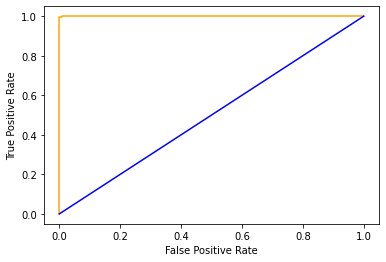

In [119]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [120]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([3.25148004e-08, 5.65703135e-08, 7.76280427e-08, 1.23981440e-07,
       1.47710628e-07, 1.78838230e-07, 1.83690118e-07, 1.99864986e-07,
       2.06341344e-07, 2.14634892e-07, 2.31096467e-07, 2.48411606e-07,
       2.49418343e-07, 2.56003842e-07, 2.60759929e-07, 2.62670682e-07,
       2.70801841e-07, 2.73001019e-07, 2.74115682e-07, 2.86899633e-07,
       2.91447512e-07, 3.05697549e-07, 3.08006845e-07, 3.20069480e-07,
       3.21636899e-07, 3.27337423e-07, 3.34137177e-07, 3.45091256e-07,
       3.49207285e-07, 3.55239592e-07, 3.73566946e-07, 3.87247137e-07,
       3.89943391e-07, 4.06127353e-07, 4.28729962e-07, 4.32559797e-07,
       4.35319970e-07, 4.39739290e-07, 4.40451827e-07, 4.47993056e-07,
       4.48730774e-07, 4.49931078e-07, 4.58939385e-07, 4.60901692e-07,
       4.61547235e-07, 4.74329794e-07, 4.77539942e-07, 4.78754084e-07,
       4.87567595e-07, 4.97710334e-07, 4.98757910e-07, 5.01876829e-07,
       5.03148950e-07, 5.04531455e-07, 5.12831580e-07, 5.21029905e-07,
      

In [121]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

In [122]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [123]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.3: 0.9972394755003451
Accuracy Score with a threshold of 0.4: 0.9972394755003451
Accuracy Score with a threshold of 0.5: 0.9972394755003451
Accuracy Score with a threshold of 0.6: 0.9972394755003451
Accuracy Score with a threshold of 0.7: 0.9972394755003451


## Voting Classifier

I will be using my top three classifiers according to PyCaret, which are; GradientBoosting, LightGradientBoostingMachine and Decision Tree

In [124]:
# Gradient Boosting Classifier

clf1 = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 300)

# Decision Tree Classifier

clf2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_split = 4)

# Light Gradient Boosting Machine

clf3 = LGBMClassifier(boosting_type = 'goss', learning_rate = 0.1)


# Create the Voting Classifier with soft voting because all models performed similarly

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)],
                               voting = 'hard')
#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

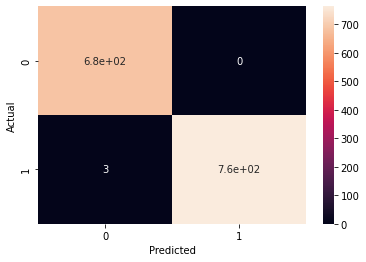

In [125]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_voting
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [126]:
# Print the Classification Report

print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       683
           1       1.00      1.00      1.00       766

    accuracy                           1.00      1449
   macro avg       1.00      1.00      1.00      1449
weighted avg       1.00      1.00      1.00      1449



In [127]:
print('Accuracy of the Voting Classifier model: {}'.format(accuracy_score(y_test, pred_voting)))

Accuracy of the Voting Classifier model: 0.9979296066252588


## Weighting to the classifier

In [138]:
# Create empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    for j in np.arange(0.1,1, 0.1):
        for k in np.arange(0.1,1, 0.1):
            clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [i, j, k])
            clf_voting.fit(X_train, y_train)
            pred = clf_voting.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

In [129]:
# Save the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Test Score'] = scores

# Create an additional column to save the sum of all the weights

test_scores['sum_weights'] = test_scores['Weight1'].add(test_scores['Weight2']).add(test_scores['Weight3'])

#We are only getting the rows that the sum of all weights were equal to one

condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

In [130]:
# Sort the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test Score', ascending = False).head(10)

,Weight1,Weight2,Weight3,Test Score,sum_weights
7,0.1,0.1,0.8,0.99793,1.0
103,0.2,0.3,0.5,0.99793,1.0
199,0.3,0.5,0.2,0.99793,1.0
15,0.1,0.2,0.7,0.99793,1.0
183,0.3,0.3,0.4,0.99793,1.0
175,0.3,0.2,0.5,0.99793,1.0
167,0.3,0.1,0.6,0.99793,1.0
119,0.2,0.5,0.3,0.99793,1.0
111,0.2,0.4,0.4,0.99793,1.0
191,0.3,0.4,0.3,0.99793,1.0


In [131]:
# Create the Voting Classifier with the most equally weighted because all models performed similarly

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [0.4, 0.3, 0.3])

#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

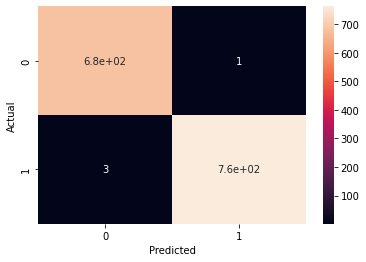

In [132]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_voting
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [133]:
# Print the Classification Report

print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       683
           1       1.00      1.00      1.00       766

    accuracy                           1.00      1449
   macro avg       1.00      1.00      1.00      1449
weighted avg       1.00      1.00      1.00      1449



### K Fold Cross Validation


In [134]:
Best = cross_val_score(clf_voting, X, y, cv=5)

In [135]:
Best

array([0.99741156, 0.99741156, 0.99913719, 0.99482312, 0.99481865])

In [136]:
Best.mean()

0.9967204173689128

The K Fold cross validation shows that we'll have an average of 0.994 accuracy with the least being 0.993 and the highest being 0.999

## Feature Importance

In [137]:
# To see the most important features, we are doing a permutation test with the voting classifier

r = permutation_importance(clf_voting , X_test, y_test, n_repeats = 30, random_state = 0)
                           
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data_balanced.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

day     0.220 +/- 0.008
month_mar0.202 +/- 0.005
duration0.134 +/- 0.007
age     0.004 +/- 0.002
balance 0.003 +/- 0.001
job_services0.002 +/- 0.000


The 'day', 'month', 'duration' feature has the highest importance with 0.2